### Pipeline for Pre-processing

In [1]:
# Importing the required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error,  r2_score
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
#import tensorflow.keras.layers as layers
from scipy.sparse import isspmatrix
import matplotlib.pyplot as plt
#from sklearn.model_selection import GridSearchCV
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
# Mouting the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!ls "/content/drive/My Drive"


Energy-Prediction-Using-BDG2-Data


In [4]:
# Loading the dataset
# Train Data
temp_df = pd.read_csv("/content/drive/My Drive/Energy-Prediction-Using-BDG2-Data/data/cleaned/train.csv", nrows=0)  # Read only the header
total_columns = len(temp_df.columns)
columns_to_use = temp_df.columns[1:total_columns]
train_data = pd.read_csv("/content/drive/My Drive/Energy-Prediction-Using-BDG2-Data/data/cleaned/train.csv",  usecols=columns_to_use)
print(train_data.head(5))

# Test Data
test_data = pd.read_csv("/content/drive/My Drive/Energy-Prediction-Using-BDG2-Data/data/cleaned/test.csv", usecols=columns_to_use)
print(test_data.head())

# Dropping the columns that are not relevant to our analysis
train_data = train_data.drop(columns=['building_name', 'site_name'])
test_data = test_data.drop(columns=['building_name', 'site_name'])

            building_name        meter        date  meter_reading site_name  \
0  Bear_education_Alfredo  electricity  2016-01-01         2.9050      Bear   
1  Bear_education_Alfredo  electricity  2016-01-02         2.7700      Bear   
2  Bear_education_Alfredo  electricity  2016-01-03         2.6725      Bear   
3  Bear_education_Alfredo  electricity  2016-01-04         4.5650      Bear   
4  Bear_education_Alfredo  electricity  2016-01-05         4.7825      Bear   

  sub_primaryspaceusage    sqm    sqft    timezone  airTemperature  \
0             Education  609.8  6564.0  US/Pacific        5.246861   
1             Education  609.8  6564.0  US/Pacific        5.993973   
2             Education  609.8  6564.0  US/Pacific        5.660314   
3             Education  609.8  6564.0  US/Pacific        5.048507   
4             Education  609.8  6564.0  US/Pacific        4.745567   

   cloudCoverage  dewTemperature  precipDepth1HR  precipDepth6HR  \
0       1.927009        0.254484    

In [5]:
# Filtering for solar meter_reading
train_data = train_data[train_data['meter'] == 'solar']
test_data = test_data[test_data['meter'] == 'solar']

train_data = train_data.drop(columns=['meter'])
test_data = test_data.drop(columns=['meter'])

In [6]:
# Inspecting the data frames
print(train_data.sample(2))
print('-------------------------------------------------------------')
print(test_data.sample(2))

             date  meter_reading sub_primaryspaceusage      sqm      sqft  \
31089  2016-12-11       119.7102        Student Center  17358.0  186840.0   
26080  2016-04-04       131.0700              Academic  11254.8  121146.0   

          timezone  airTemperature  cloudCoverage  dewTemperature  \
31089  US/Mountain        4.960440       2.158598        1.325934   
26080  US/Mountain       10.475877       1.930225        2.050877   

       precipDepth1HR  precipDepth6HR  seaLvlPressure  windDirection  \
31089        0.558275       11.229932     1023.512693     157.514351   
26080        0.380880       12.085381     1014.273334     180.232336   

       windSpeed  season  building_id  site_id  
31089   2.724666  Winter           72        2  
26080   3.516447  Spring           68        2  
-------------------------------------------------------------
             date  meter_reading sub_primaryspaceusage      sqm      sqft  \
25985  2017-03-12            0.0              Academic  1

In [7]:
# Separating into X and Y dataframes
X_train = train_data.drop(columns=['meter_reading'])  # Exclude target variable
y_train = train_data['meter_reading']

X_test = test_data.drop(columns=['meter_reading'])  # Exclude target variable
y_test = test_data['meter_reading']

#### Setting up a pipeline to process the data

In [8]:
# Convert 'site_id' from numeric to categorical
X_train['site_id'] = X_train['site_id'].astype('category')
X_test['site_id'] = X_test['site_id'].astype('category')

# Making sure the date columns is in the right format
X_train['date'] = pd.to_datetime(X_train['date'])
X_test['date'] = pd.to_datetime(X_test['date'])

In [9]:
print(X_train.dtypes)
print(X_train.columns)

date                     datetime64[ns]
sub_primaryspaceusage            object
sqm                             float64
sqft                            float64
timezone                         object
airTemperature                  float64
cloudCoverage                   float64
dewTemperature                  float64
precipDepth1HR                  float64
precipDepth6HR                  float64
seaLvlPressure                  float64
windDirection                   float64
windSpeed                       float64
season                           object
building_id                       int64
site_id                        category
dtype: object
Index(['date', 'sub_primaryspaceusage', 'sqm', 'sqft', 'timezone',
       'airTemperature', 'cloudCoverage', 'dewTemperature', 'precipDepth1HR',
       'precipDepth6HR', 'seaLvlPressure', 'windDirection', 'windSpeed',
       'season', 'building_id', 'site_id'],
      dtype='object')


In [10]:
# Define features and types based on your dataset
numerical_features = ['sqm', 'sqft', 'airTemperature', 'cloudCoverage', 'dewTemperature',
                      'precipDepth1HR', 'precipDepth6HR', 'seaLvlPressure', 'windDirection', 'windSpeed']
categorical_features = ['timezone', 'season', 'sub_primaryspaceusage', 'site_id']
date_feature = 'date'
id_feature = 'building_id'

In [11]:
# Save the 'building_id' and 'date' columns
building_ids_train = X_train[id_feature].values
dates_train = X_train[date_feature].values
building_ids_test = X_test[id_feature].values
dates_test = X_test[date_feature].values

In [12]:
# Drop the 'building_id' and 'date' columns for preprocessing
X_train = X_train.drop(columns=[id_feature, date_feature])
X_test = X_test.drop(columns=[id_feature, date_feature])

# Create a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Fit the preprocessor on the training data and transform both training and test data
preprocessor.fit(X_train)
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [13]:
# Convert the processed data back to dense DataFrames
# X_train_processed_df = pd.DataFrame(X_train_processed.toarray(), columns=preprocessor.get_feature_names_out())
# X_test_processed_df = pd.DataFrame(X_test_processed.toarray(), columns=preprocessor.get_feature_names_out())


X_train_processed_df = pd.DataFrame(X_train_processed, columns=preprocessor.get_feature_names_out())
X_test_processed_df = pd.DataFrame(X_test_processed, columns=preprocessor.get_feature_names_out())

In [14]:
# Reattach the 'building_id' and 'date' columns to the processed data
X_train_processed_df[id_feature] = building_ids_train
X_train_processed_df[date_feature] = dates_train
X_test_processed_df[id_feature] = building_ids_test
X_test_processed_df[date_feature] = dates_test

# Sort the DataFrames by 'building_id' and 'date' to ensure the correct sequence
X_train_processed_df.sort_values(by=[id_feature, date_feature], inplace=True)
X_test_processed_df.sort_values(by=[id_feature, date_feature], inplace=True)

In [15]:
X_train_processed_df.columns

Index(['num__sqm', 'num__sqft', 'num__airTemperature', 'num__cloudCoverage',
       'num__dewTemperature', 'num__precipDepth1HR', 'num__precipDepth6HR',
       'num__seaLvlPressure', 'num__windDirection', 'num__windSpeed',
       'cat__timezone_US/Mountain', 'cat__season_Fall', 'cat__season_Spring',
       'cat__season_Summer', 'cat__season_Winter',
       'cat__sub_primaryspaceusage_Academic',
       'cat__sub_primaryspaceusage_Student Center', 'cat__site_id_2',
       'building_id', 'date'],
      dtype='object')

In [16]:
# Assume y_train and y_test are Pandas Series with 'meter_reading' for training and testing datasets
y_train_scaled = np.log1p(y_train.values.reshape(-1, 1))
y_test_scaled = np.log1p(y_test.values.reshape(-1, 1))

In [17]:
# Making it suitable for timeseries data
sequence_length = 5

def create_sequences(data, target, sequence_length):
    X = []
    y = []
    for i in range(sequence_length, data.shape[0]):  # Start from sequence_length
        if isspmatrix(data):  # Check if 'data' is a sparse matrix
            seq = data[(i - sequence_length):i].toarray()  # Convert to dense array
        else:  # If 'data' is already a dense array or DataFrame
            seq = data.iloc[(i - sequence_length):i].values if hasattr(data, 'iloc') else data[(i - sequence_length):i]
        X.append(seq)
        y.append(target[i])
    return np.array(X), np.array(y)

# Ensure y_train_scaled and y_test_scaled are numpy arrays for consistency
y_train_scaled = np.array(y_train_scaled).flatten()
y_test_scaled = np.array(y_test_scaled).flatten()

# Create sequences using the modified function
X_train_sequences, y_train_scaled_sequences = create_sequences(X_train_processed, y_train_scaled, sequence_length)
X_test_sequences, y_test_scaled_sequences = create_sequences(X_test_processed, y_test_scaled, sequence_length)


#### Fitting the RNN

In [18]:
param_grid = {
    'lstm_units': [20, 50, 100],
    'activation': ['relu', 'tanh', 'sigmoid'],
    'batch_size': [16, 32, 64],
    'epochs': [10, 20],
    'optimizer': ['adam', 'rmsprop']
}

In [19]:
# Define RNN model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train_sequences.shape[1], X_train_sequences.shape[2])))
model.add(Dense(1))  # The output layer with one neuron, as we are doing regression to predict 'meter reading'
model.compile(optimizer='adam', loss='mse')

# Fit the RNN model on the training data
history = model.fit(X_train_sequences, y_train_scaled, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
28/28 [==============================] - 2s 18ms/step - loss: 19.7940 - val_loss: 3.7727
Epoch 2/10
28/28 [==============================] - 0s 8ms/step - loss: 8.9010 - val_loss: 1.5193
Epoch 3/10
28/28 [==============================] - 0s 7ms/step - loss: 7.3738 - val_loss: 2.3385
Epoch 4/10
28/28 [==============================] - 0s 7ms/step - loss: 7.1206 - val_loss: 2.4745
Epoch 5/10
28/28 [==============================] - 0s 7ms/step - loss: 6.8957 - val_loss: 2.9684
Epoch 6/10
28/28 [==============================] - 0s 7ms/step - loss: 6.6010 - val_loss: 2.1794
Epoch 7/10
28/28 [==============================] - 0s 8ms/step - loss: 6.3644 - val_loss: 2.5524
Epoch 8/10
28/28 [==============================] - 0s 7ms/step - loss: 6.2687 - val_loss: 2.7582
Epoch 9/10
28/28 [==============================] - 0s 7ms/step - loss: 6.2321 - val_loss: 1.2632
Epoch 10/10
28/28 [==============================] - 0s 7ms/step - loss: 6.2116 - val_loss: 1.6867


In [20]:
# Evaluate the model on the test data
y_pred_scaled = model.predict(X_test_sequences)
y_pred_scaled = np.nan_to_num(y_pred_scaled, nan=0)
y_test_scaled = y_test_scaled[sequence_length:]

# Inverse the scaling of the predictions to get them on the same scale as the original 'meter reading' data
#y_pred = scaler.inverse_transform(y_pred_scaled)
#y_true = scaler.inverse_transform(y_test_scaled.reshape(-1, 1))  # Reshape if y_test_scaled is a 1D array

# Calculate MSE and R^2
mse = mean_squared_error(y_test_scaled, y_pred_scaled)
r_squared = r2_score(y_test_scaled, y_pred_scaled)

print(f'Mean Squared Error (MSE) on Test Data: {mse}')
print(f'R-squared Score on Test Data: {r_squared}')

35/35 [==============================] - 0s 4ms/step
Mean Squared Error (MSE) on Test Data: 8.214397655782388
R-squared Score on Test Data: 0.015560765705619373


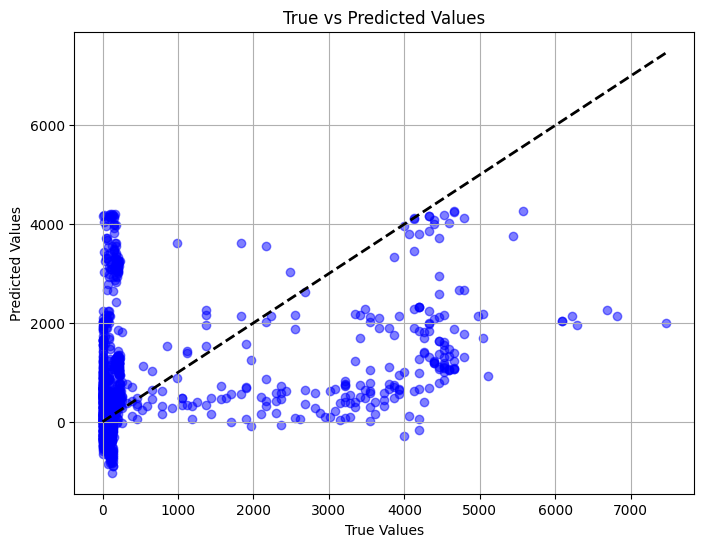

In [ ]:
# Plotting y_pred against y_true
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, color='blue', alpha=0.5)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2)  # Plotting the diagonal line
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
plt.grid(True)
plt.show()

##### Hyperparameter tuning

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping

def create_rnn_model(input_shape, units, learning_rate):
    model = Sequential([
        LSTM(units=50, activation='relu', input_shape=(sequence_length, num_features), return_sequences=False)
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

# Hyperparameters to tune
hyperparameters = {
    'units': [20, 50],  # Reduced from three values to two
    'learning_rate': [0.001, 0.01]  # Reduced from three values to two
}

In [23]:
n_splits = 2  # Adjust based on your data size
tscv = TimeSeriesSplit(n_splits=n_splits)
input_shape = (X_train_sequences.shape[1], X_train_sequences.shape[2])

best_mse = float('inf')
best_hyperparams = {}

for units in hyperparameters['units']:
    for learning_rate in hyperparameters['learning_rate']:
        fold_mse = []  # Store the MSE of each fold

        for train_index, val_index in tscv.split(X_train_sequences):
            X_train_fold, X_val_fold = X_train_sequences[train_index], X_train_sequences[val_index]
            y_train_fold, y_val_fold = X_train_sequences[train_index], X_train_sequences[val_index]

            model = create_rnn_model(input_shape, units, learning_rate)

            early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min')  # Reduced patience


            model.fit(X_train_fold, y_train_fold, epochs=5, batch_size=64,
                      validation_data=(X_val_fold, y_val_fold), callbacks=[early_stopping], verbose=0)

            y_pred_fold = model.predict(X_val_fold)
            mse = mean_squared_error(y_val_fold, y_pred_fold)
            fold_mse.append(mse)

        avg_mse = np.mean(fold_mse)
        print(f'Average MSE for units={units}, lr={learning_rate}: {avg_mse}')

        if avg_mse < best_mse:
            best_mse = avg_mse
            best_hyperparams = {'units': units, 'learning_rate': learning_rate}

print(f'Best hyperparameters: {best_hyperparams} with MSE: {best_mse}')

NameError: name 'num_features' is not defined

In [27]:
# Define RNN model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train_sequences.shape[1], X_train_sequences.shape[2])))
model.add(Dense(1))  # The output layer with one neuron, as we are doing regression to predict 'meter reading'
model.compile(optimizer='rmsprop', loss='mse')

# Fit the RNN model on the training data
history = model.fit(X_train_sequences, y_train_scaled, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model on the test data
y_pred_scaled = model.predict(X_test_sequences)
y_pred_scaled = np.nan_to_num(y_pred_scaled, nan=0)
#y_test_scaled = y_test_scaled[sequence_length:]

# Inverse the scaling of the predictions to get them on the same scale as the original 'meter reading' data
#y_pred = scaler.inverse_transform(y_pred_scaled)
#y_true = scaler.inverse_transform(y_test_scaled.reshape(-1, 1))  # Reshape if y_test_scaled is a 1D array

# Calculate MSE and R^2
mse = mean_squared_error(y_test_scaled, y_pred_scaled)
r_squared = r2_score(y_test_scaled, y_pred_scaled)

print(f'Mean Squared Error (MSE) on Test Data: {mse}')
print(f'R-squared Score on Test Data: {r_squared}')

Epoch 1/10
28/28 [==============================] - 3s 27ms/step - loss: 14.6470 - val_loss: 1.0138
Epoch 2/10
28/28 [==============================] - 0s 12ms/step - loss: 7.8116 - val_loss: 0.7469
Epoch 3/10
28/28 [==============================] - 0s 12ms/step - loss: 7.1594 - val_loss: 1.3498
Epoch 4/10
28/28 [==============================] - 0s 12ms/step - loss: 6.8648 - val_loss: 1.9596
Epoch 5/10
28/28 [==============================] - 0s 12ms/step - loss: 6.4811 - val_loss: 4.7456
Epoch 6/10
28/28 [==============================] - 0s 11ms/step - loss: 6.6189 - val_loss: 5.4652
Epoch 7/10
28/28 [==============================] - 0s 7ms/step - loss: 6.4626 - val_loss: 5.6528
Epoch 8/10
28/28 [==============================] - 0s 6ms/step - loss: 6.3285 - val_loss: 10.1578
Epoch 9/10
28/28 [==============================] - 0s 7ms/step - loss: 6.4008 - val_loss: 8.6037
Epoch 10/10
35/35 [==============================] - 0s 3ms/step
Mean Squared Error (MSE) on Test Data: 10.070

In [28]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [ ]:
def create_rnn_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, activation='relu', input_shape=input_shape))
    model.add(Dense(1))  # Assuming a regression problem
    model.compile(optimizer='adam', loss='mse')
    return model

In [29]:
n_splits = 5  # For example, change according to your dataset size and needs
tscv = TimeSeriesSplit(n_splits=n_splits)
input_shape = (X_train.shape[1], X_train.shape[2])  # Make sure this matches your data

for train_index, val_index in tscv.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Create a new instance of the model for each fold
    model = create_rnn_model(input_shape)

    # Early stopping to avoid overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')

    # Fit the model
    history = model.fit(X_train_fold, y_train_fold,
                        epochs=10,
                        batch_size=32,
                        validation_data=(X_val_fold, y_val_fold),
                        callbacks=[early_stopping],
                        verbose=1)

    # Predict on the validation set
    y_pred_fold = model.predict(X_val_fold)

    # Evaluate the model
    mse = mean_squared_error(y_val_fold, y_pred_fold)
    print(f'MSE for this fold: {mse}')

IndexError: tuple index out of range

In [30]:
tscv = TimeSeriesSplit(n_splits=n_splits)

In [ ]:
def create_rnn_model(lstm_units=50, activation='relu', optimizer='adam', input_shape=(None, None)):
    # Define the model
    model = Sequential()
    model.add(LSTM(units=lstm_units, activation=activation, input_shape=input_shape))  # Adjust according to your data
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Initialize the KerasRegressor with the shape of training sequences
model = KerasRegressor(build_fn=lambda: create_rnn_model(input_shape=(X_train_sequences.shape[1], X_train_sequences.shape[2])))


# Define the parameter grid, note the changes in prefix for model-specific parameters
param_grid = {
    'model__lstm_units': [20, 50, 100],
    'model__activation': ['relu', 'tanh', 'sigmoid'],
    'batch_size': [16, 32, 64],
    'epochs': [10, 20],
    'model__optimizer': ['adam', 'rmsprop']  # Prefix 'model__' is important here
}

# Setup GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, scoring='neg_mean_squared_error')


# Perform the grid search
grid_result = grid.fit(X_train_sequences, y_train_scaled[sequence_length:])

# Summarize the results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))



In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Define your custom model creation function
def create_rnn_model(lstm_units=50, activation='relu', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units=lstm_units, activation=activation, input_shape=(5, 48)))  # Adjust based on your data shape
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Instantiate the KerasRegressor
model = KerasRegressor(model=create_rnn_model, model__lstm_units=50, model__activation='relu', model__optimizer='adam', epochs=100, batch_size=10)

param_grid = {
    'model__lstm_units': [20, 50, 100],
    'model__activation': ['relu', 'tanh', 'sigmoid'],
    'model__optimizer': ['adam', 'rmsprop'],
    'batch_size': [16, 32, 64],
    'epochs': [10, 20]
}

from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, scoring='neg_mean_squared_error')
grid_result = grid.fit(X_train_sequences, y_train_scaled[sequence_length:])

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


In [22]:
X_test_processed_df.sample()

,num__sqm,num__sqft,num__airTemperature,num__cloudCoverage,num__dewTemperature,num__precipDepth1HR,num__precipDepth6HR,num__seaLvlPressure,num__windDirection,num__windSpeed,cat__timezone_US/Mountain,cat__season_Fall,cat__season_Spring,cat__season_Summer,cat__season_Winter,cat__sub_primaryspaceusage_Academic,cat__sub_primaryspaceusage_Student Center,cat__site_id_2,building_id,date
434,0.0,0.0,0.252036,0.574781,0.214717,0.063182,0.140461,0.574005,0.648689,0.373421,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,71,2017-03-11


In [23]:
X_train_processed_df.sample()

,num__sqm,num__sqft,num__airTemperature,num__cloudCoverage,num__dewTemperature,num__precipDepth1HR,num__precipDepth6HR,num__seaLvlPressure,num__windDirection,num__windSpeed,cat__timezone_US/Mountain,cat__season_Fall,cat__season_Spring,cat__season_Summer,cat__season_Winter,cat__sub_primaryspaceusage_Academic,cat__sub_primaryspaceusage_Student Center,cat__site_id_2,building_id,date
293,0.103275,0.103276,0.610029,0.222161,0.668637,0.236525,0.083877,0.504633,0.491265,0.166299,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,68,2016-10-20


In [25]:
y_test_scaled

array([0., 0., 0., ..., 0., 0., 0.])

In [26]:
y_train_scaled

array([0.35833554, 0.30000198, 0.31666888, ..., 0.02011871, 0.01887893,
       0.00497436])

In [27]:
y_test

25915    6815.7426
25916    7340.0285
25917    1179.6513
25918       0.0000
25919       0.0000
           ...    
31020       0.0000
31021       0.0000
31022       0.0000
31023       0.0000
31024       0.0000
Name: meter_reading, Length: 1095, dtype: float64

In [28]:
y_train

25986    2818.0658
25987    2359.3120
25988    2490.3858
25989    1966.1010
25990    2621.4415
           ...    
31105      22.2200
31106      86.1300
31107     158.2200
31108     148.4700
31109      39.1200
Name: meter_reading, Length: 1098, dtype: float64

In [29]:
test_data.tail()

,date,meter_reading,sub_primaryspaceusage,sqm,sqft,timezone,airTemperature,cloudCoverage,dewTemperature,precipDepth1HR,precipDepth6HR,seaLvlPressure,windDirection,windSpeed,season,building_id,site_id
31020,2017-12-27,0.0,Student Center,17358.0,186840.0,US/Mountain,0.148770,1.727177,-4.908725,0.319127,11.634468,1020.046240,217.730218,3.687248,Winter,72,2
31021,2017-12-28,0.0,Student Center,17358.0,186840.0,US/Mountain,-0.844098,1.555937,-6.204677,0.334733,10.882579,1023.015464,220.044428,3.277060,Winter,72,2
31022,2017-12-29,0.0,Student Center,17358.0,186840.0,US/Mountain,0.168282,2.037777,-5.045740,0.255286,10.993293,1018.470049,203.160684,3.687334,Winter,72,2
31023,2017-12-30,0.0,Student Center,17358.0,186840.0,US/Mountain,1.567716,2.108643,-3.203027,0.233554,10.862294,1014.599862,197.386918,4.084761,Winter,72,2
31024,2017-12-31,0.0,Student Center,17358.0,186840.0,US/Mountain,0.189310,1.886480,-5.218486,0.258218,11.111977,1017.914070,216.515384,4.398441,Winter,72,2


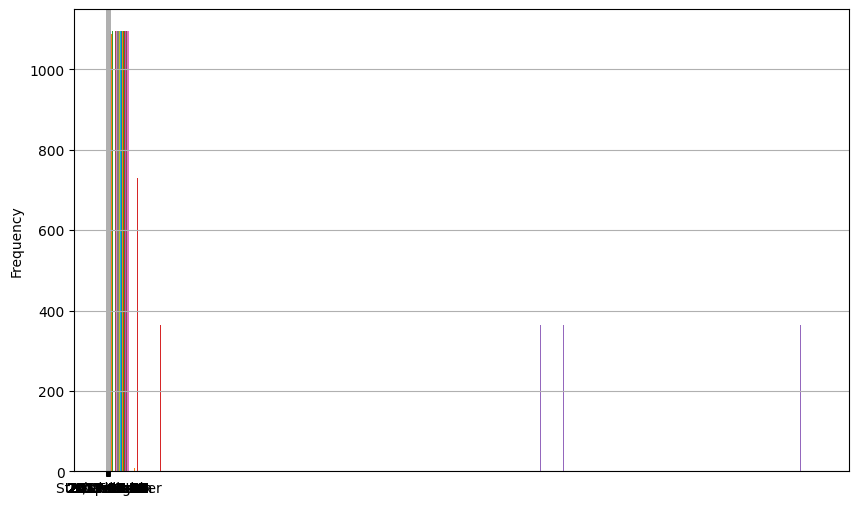

In [32]:
# Extract the column you want to plot


# Plot the histogram
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
plt.hist(test_data, bins=30)  # Adjust the number of bins as needed
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [41]:
train_data['date'].nunique()

366

In [42]:
test_data['date'].nunique()

365

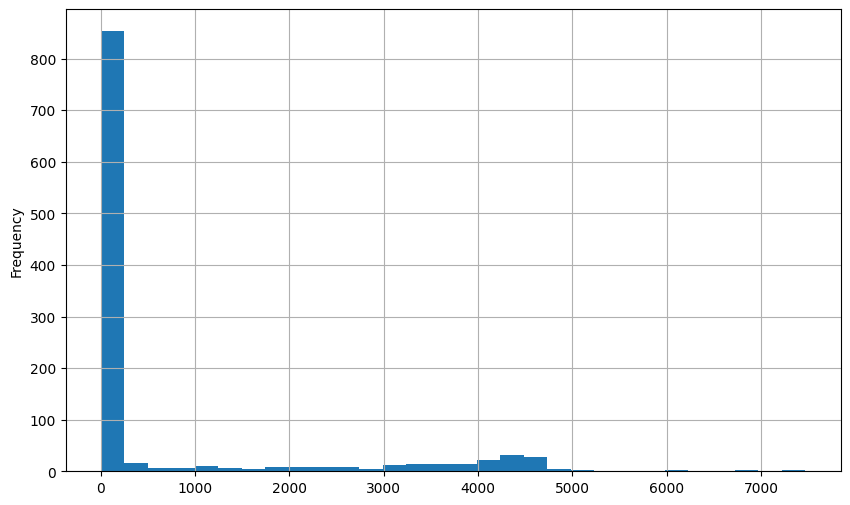

In [44]:
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
plt.hist(test_data['meter_reading'], bins=30)  # Adjust the number of bins as needed
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
